In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import math

import pybnb
from fbm import FBM
import networkx as nx

from transformers import *
from branch_and_bound_warped_pvar import BnBWarping

# Tree structure

In [3]:
n_points = 4

x = np.sin(np.linspace(0, 2*np.pi, n_points))
y = np.cos(np.linspace(0, 3*np.pi, n_points))

x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

depth = 2
p = 1.35
norm = 'l1'

options = {'node_color': 'blue',
           'node_size': 2,
           'width': 1,
           'font':2,
           'with_labels':False}

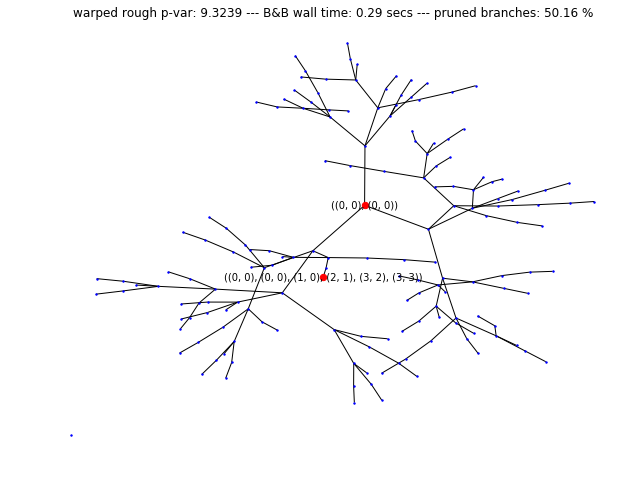

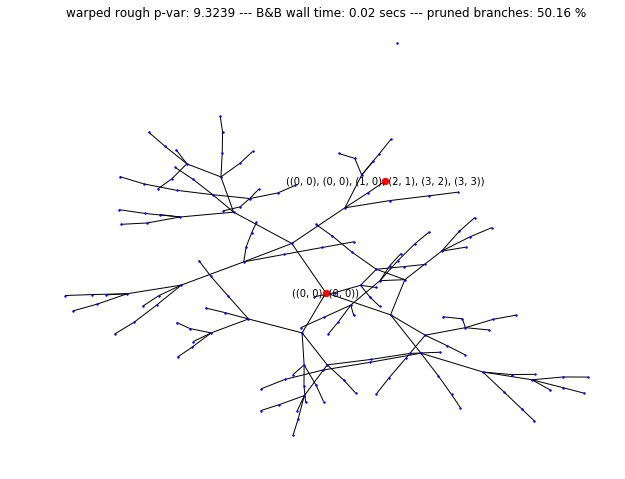

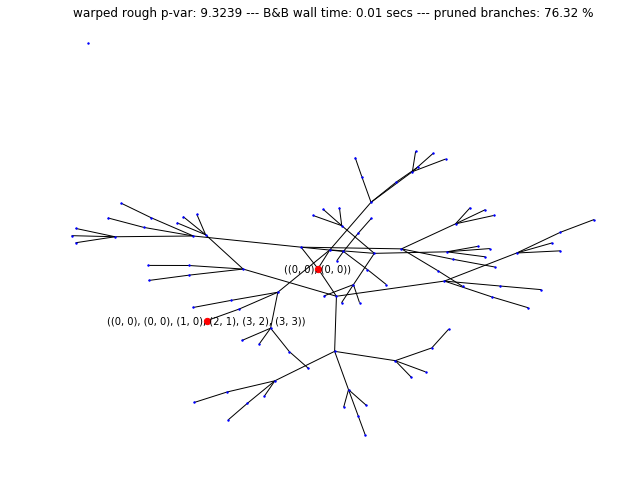

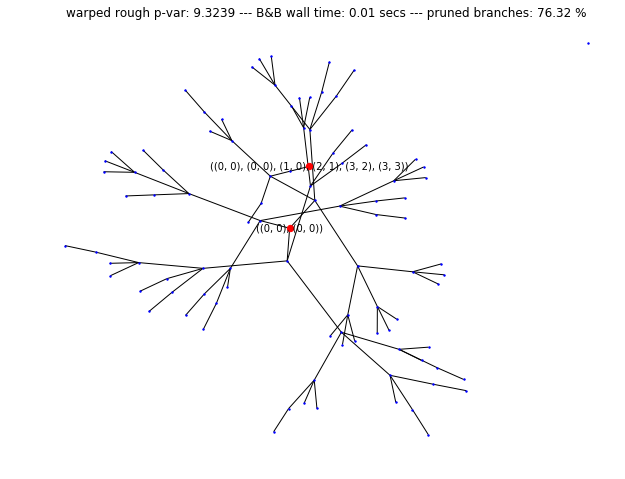

In [4]:
for b1, b2, b3 in [(False, False, False), (True, False, False), (True, True, False), (True, True, True)]:

    problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=3, record_path=True,
                         plot_2d=True, pvar_dist_mem=None, pvar_mem_org=None, 
                         initial_time=None, use_bound1=b1, use_bound2=b2, use_bound3=b3)

    solver = pybnb.Solver()

    # results = solver.solve(problem, log=None, queue_strategy='depth')
    results = solver.solve(problem, log=None, queue_strategy='breadth')
    # results = solver.solve(problem, log=None, queue_strategy=('depth', 'random'))

    best_warp = results.best_node.state
    tot_nodes = problem.Delannoy_number(n_points, n_points)
    processed_nodes = results.nodes
    perc_pruned = 100.*(tot_nodes - processed_nodes)/tot_nodes
    
    G = nx.Graph()
    G.add_node(problem.nodes[0])
    for n, e in zip(problem.nodes[1:], problem.edges):
        G.add_node(n)
        G.add_edge(e[0], e[1])

    important_nodes = [((0, 0), (0, 0)), tuple(best_warp)]
    labels = {}    
    for node in G.nodes():
        if node in important_nodes:
            #set the node name as the key and the label as its value 
            labels[node] = node

    pos = nx.spring_layout(G)
    # pos = nx.shell_layout(G)
    # pos = nx.spectral_layout(G)
    # pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(8,6))
    nx.draw(G, pos, **options)
    plt.title('warped rough p-var: {:.4f} --- B&B wall time: {:.2f} secs --- pruned branches: {:.2f} %'.format(results.objective, 
                                                                                                               results.wall_time, 
                                                                                                               perc_pruned))
    nx.draw_networkx_labels(G, pos, labels, font_size=10, node_color='r')
    nx.draw_networkx_nodes(G, pos, important_nodes, node_color='r', node_size=40)

# Memoization

In [154]:
n_points = 12

x = np.sin(np.linspace(0, 4*np.pi, n_points))
y = np.cos(np.linspace(0, 2*np.pi, n_points))

x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

In [155]:
problem = BnBWarping(x=x, y=y, p=1.5, depth=2, norm='l1', root_node=(0, 0), bc=3, record_path=True,
                     cache_size=None, plot_2d=True, pvar_dist_mem=None, pvar_mem_org=None, 
                     initial_time=None, use_bound1=True, use_bound2=True, use_bound3=True)
        
solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')
# results = solver.solve(problem, log=None, queue_strategy='breadth')
# results = solver.solve(problem, log=None, queue_strategy=('depth', 'random'))

In [156]:
df_memoization = pd.DataFrame.from_dict(problem.pvar_mem_org, orient='index').T

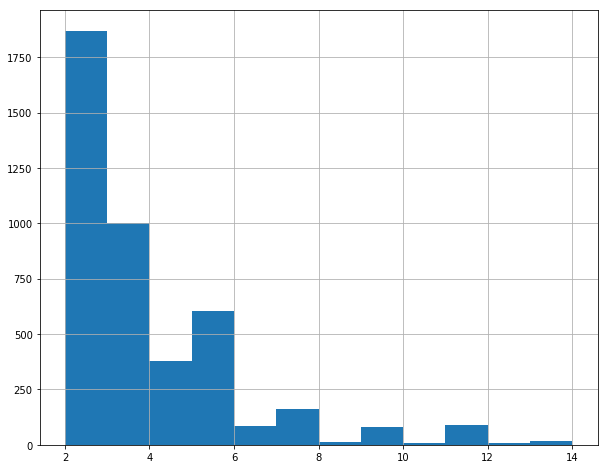

In [157]:
plt.figure(figsize=(10,8))
df_memoization.count().hist(bins=range(2, 15))
plt.show()

In [208]:
# only select paths with more than 1 memoization hit
df = df_memoization.T[df_memoization.isna().sum()<len(df_memoization.index)-1].fillna(math.inf)

In [214]:
n_splits = 10
bins = [0.]
for s in np.array_split(np.array(sorted(pd.unique(df.values.ravel('K')))), n_splits):
    bins.append(s[-1])

In [215]:
values = []
names = []
for c in df.columns:
    obj = pd.cut(df[c], bins).value_counts()
    values.append(obj.values)
    names.append(obj.name)

df = pd.DataFrame(values).T
df.index = bins[1:]
df.columns = names

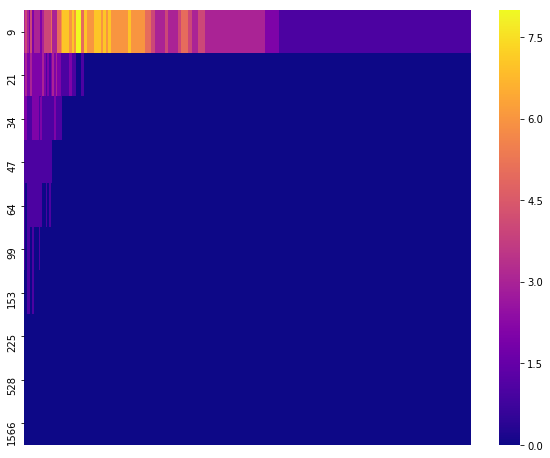

In [216]:
plt.figure(figsize=(10, 8))
seaborn.heatmap(df, xticklabels=False, yticklabels=True, cmap="plasma")
plt.show()

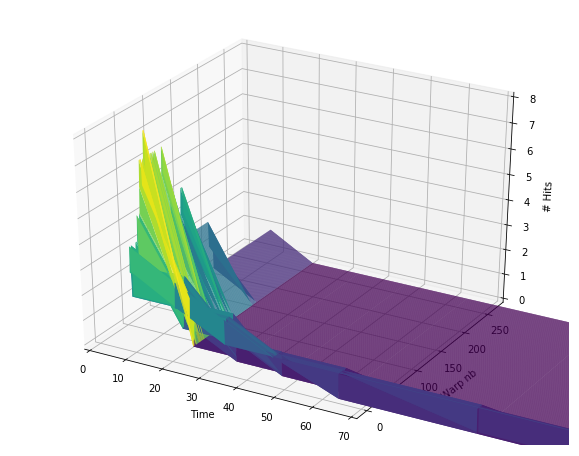

In [267]:
x,y = np.meshgrid(df.columns.astype(float), df.index)
z = df.values

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 8))


# rgb = LightSource(270, 45).shade(z, cmap=plt.cm.jet, vert_exag=0.2, blend_mode='soft')
surf = ax.plot_surface(y, x, z, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=True, shade=False)

ax.set_xlim(0, 70)
# ax.set_ylim(0, 200)
# ax.set_zlim(4, 10)

ax.set_xlabel('Time')
ax.set_ylabel('Warp nb')
ax.set_zlabel('# Hits')

plt.show()